**EXTRACTING THE CRASH DETAILS FROM API**

In [31]:
import requests
import json
from bs4 import BeautifulSoup
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from collections import defaultdict

#Creating a dataframe with 3 columns- State Case, Weather, Light_Type
final_dataframe1 = pd.DataFrame(columns = [
        "State Case",
        "Weather",
        "Light_Type"
    ])

#Defining a function 'crash_details' to extract data related to the 3 columns from the API 
def crash_details(state_Case, year, state_id):
    data_list = list()
    url = f'https://crashviewer.nhtsa.dot.gov/CrashAPI//crashes/GetCaseDetails?stateCase={state_Case}&caseYear={year}&state={state_id}&format=json'
    page = requests.get(url)
    data = page.text
    parse_json = json.loads(data)
    argument_crash = defaultdict(list)
    try:
        data_list.append(parse_json['Results'][0][0]['CrashResultSet']['ST_CASE'])
    except:
        data_list.append(None)
    try:
        data_list.append(parse_json['Results'][0][0]['CrashResultSet']['WEATHER1NAME'])
    except:
        data_list.append(None)
    try:
        data_list.append(parse_json['Results'][0][0]['CrashResultSet']['LGT_CONDNAME'])
    except:
        data_list.append(None)
    return data_list

# A for loop to traverse through all the case_ids for the year=2014 and state=1 and finally append it to the 'final_dataframe1'
case_id = 10002
case_id_end = 10812
year = 2014
state = 1
for i in range(case_id,case_id_end,1):
   data_list = crash_details(i,year,state)
   final_dataframe1.loc[len(final_dataframe1)] = data_list
#    print(final_dataframe1)
# final_dataframe1.to_csv('State_1_Crash_Details.csv')

# Grouping values that almost mean the same in 'Weather' and 'Light_Type' columns, thus reducing the various categories inside respective columns
final_dataframe1['Weather'].replace({'Cloudy':'Clear','Unknown':'Not Reported','Other':'Not Reported','Sleet, Hail (Freezing Rain or Drizzle)':'Rain','Freezing Rain or Drizzle':'Rain'}, inplace = True)
final_dataframe1['Light_Type'].replace({'Dark - Not Lighted':'Dark','Dark - Lighted': 'Dark','Dark - Unknown Lighting':'Dark','Not Reported':'Dark','Other':'Dark','Unknown':'Dark','Dawn':'Dawn/Dusk','Dusk':'Dawn/Dusk'}, inplace = True)
final_dataframe1.dropna(inplace = True)

# Using OneHotEncoding to convert the text-descriptions to numeric values
ohe = OneHotEncoder(handle_unknown = 'ignore')
encoder_df = pd.DataFrame(ohe.fit_transform(final_dataframe1[['Weather']]).toarray())
encoder_df1 = pd.DataFrame(ohe.fit_transform(final_dataframe1[['Light_Type']]).toarray())
encoder_df.rename(columns = {0 : 'Clear', 1 : 'Fog, Smog, Smoke',2: 'Weather Not Reported',3: 'Rain',4: 'Snow'}, inplace = True)
encoder_df1.rename(columns = {0 : 'Dark', 1 : 'Dawn/Dusk',2: 'Daylight'}, inplace = True)

# Concatenating the 'final_dataframe1', 'encoder_df', 'encoder_df1' dataframes together in the 'final_df'
final_df = pd.concat([final_dataframe1.dropna(),encoder_df.dropna(), encoder_df1.dropna()], axis = "columns" )
# Removing the NAs if any from the dataframe and restricting the changes to the same dataframe 
final_df.dropna(inplace = True)
#Converting the dataframe to a CSV
final_df.to_csv('Crash_Details.csv')
    


**EXTRACTING THE OCCUPANT DATA FROM THE API**

In [32]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd
from collections import defaultdict

# Defining a function 'crash_by_occupant' to extract data related to the occupant from the API
def crash_by_occupant(age, sex, seat_pos, injury_sev, from_caseyear, to_caseyear, state, include_occupants, include_nonoccupants):
    url = f"https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCrashesByPerson?age={age}&sex={sex}&seatPos={seat_pos}&injurySeverity={injury_sev}&fromCaseYear={from_caseyear}&toCaseYear={to_caseyear}&state={state}&includeOccupants={include_occupants}&includeNonOccupants={include_nonoccupants}&format=json"
    page = requests.get(url)
    # print(page.status_code)
    # soup = BeautifulSoup(page.text,'html.parser')
    # print(soup.prettify())
    data = page.text
    parse_json = json.loads(data)
    # print(type(parse_json))
    # print(parse_json)
    attributeDict = defaultdict(list)
    for attribute in parse_json["Results"][0]:
        attributeDict["State Case"].append(attribute["ST_CASE"])
        attributeDict["Age"].append(attribute["AGE"])
        attributeDict["Sex"].append(attribute["SEX"])
        # attributeDict["Sex_Name"].append(attribute["SEXNAME"])
        # attributeDict["Seat"].append(attribute["SEAT_POS"])
        # attributeDict["Seat_pos"].append(attribute["SEAT_POSNAME"])
        # attributeDict["Fatality"].append(attribute["DEATH_HRNAME"])
        attributeDict["Drinking_Involvement"].append(attribute["DRINKING"])
        attributeDict["Drugs_involvement"].append(attribute["DRUGS"])
        attributeDict["Injury_Severity"].append(attribute["INJ_SEV"])
        attributeDict["Race_Involvement"].append(attribute["RACE"])
        attributeDict["Rollover"].append(attribute["ROLLOVER"])
        attributeDict["Case Year"].append(attribute["CaseYear"])
        # attributeDict["SchoolBus_involvement"].append(attribute["SCH_BUS"])
        # attributeDict["Vehicle_withTrailers"].append(attribute["TOW_VEH"])
        dataframe = pd.DataFrame(attributeDict)
        # dataframe.set_index('CASE_ID')
        # dataframe.sort_index()
        return dataframe

# A for loop to extract data from the API for a given range of ages, sex, and injury_severity
age_upper_limit = 71
age_lower_limit = 18
crash_occupant_df = pd.DataFrame()
for i in range(age_lower_limit, age_upper_limit,1):
    for j in range(1,3,1):
        for k in range(1,5,1):
          crash_occupant_df = crash_occupant_df.append(crash_by_occupant(i,j,11,k,2014,2014,1,True,True))
            

# Repalcing the numeric values present in the columns 'Drinking_Involvement', 'Drugs_Involvement', 'Race_Involvement', 'Rollover'
# Restricting the changes to the same dataframe
crash_occupant_df['Drinking_Involvement'].replace({'8':'2','9':'2'}, inplace = True)
crash_occupant_df['Drugs_involvement'].replace(to_replace = {'8':'2','9':'2'}, inplace = True)
crash_occupant_df['Race_Involvement'].replace(to_replace = {'2':'1','3':'1'}, inplace = True)
crash_occupant_df['Rollover'].replace({'2':'1'}, inplace = True)

# Converting the dataframe into a CSV
crash_occupant_df.to_csv("Crash_Occupant.csv")


<ipython-input-32-24866b379530>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crash_occupant_df = crash_occupant_df.append(crash_by_occupant(i,j,11,k,2014,2014,1,True,True))
<ipython-input-32-24866b379530>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crash_occupant_df = crash_occupant_df.append(crash_by_occupant(i,j,11,k,2014,2014,1,True,True))
<ipython-input-32-24866b379530>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crash_occupant_df = crash_occupant_df.append(crash_by_occupant(i,j,11,k,2014,2014,1,True,True))
<ipython-input-32-24866b379530>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crash_occupant_df = crash_oc

**MERGING THE DATAFRAMES CONTAINING OCCUPANT AND CRASH DETAILS**

In [33]:
# Merging the dataframes created for the Occupant and Crash details, based on a common column('State Case')
inner_join = pd.merge(
    crash_occupant_df,
    final_df,
    on = 'State Case',
    how = 'inner')

# Saving the merged data to a CSV
inner_join.to_csv('FD_State_1,2014.csv')

In [34]:
inner_join.isna().sum()

State Case              0
Age                     0
Sex                     0
Drinking_Involvement    0
Drugs_involvement       0
Injury_Severity         0
Race_Involvement        0
Rollover                0
Case Year               0
Weather                 0
Light_Type              0
Clear                   0
Fog, Smog, Smoke        0
Weather Not Reported    0
Rain                    0
Snow                    0
Dark                    0
Dawn/Dusk               0
Daylight                0
dtype: int64

**PIE-CHARTS FOR DRINKING/DRUGS/ROLLOVER/RACE**

([<matplotlib.patches.Wedge at 0x7fd27862a8c0>,
 [Text(-0.7876079465992677, 0.7679021568231758, 'No Rollover of Vehicle'),
  Text(0.7876079465992676, -0.767902156823176, 'Vehicle Rollover Reported')],
 [Text(-0.4296043345086914, 0.4188557219035504, '75.4%'),
  Text(0.42960433450869134, -0.41885572190355047, '24.6%')])

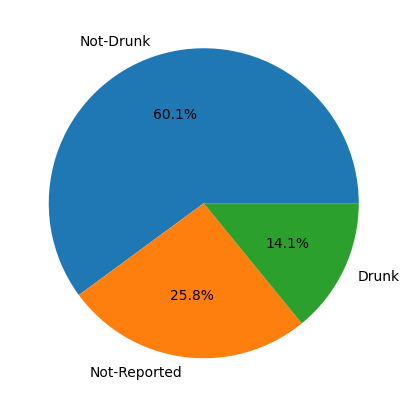

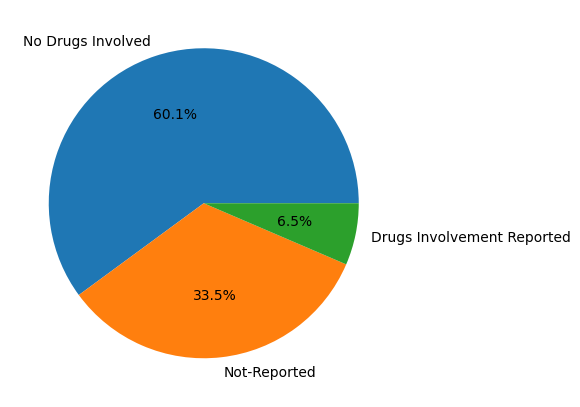

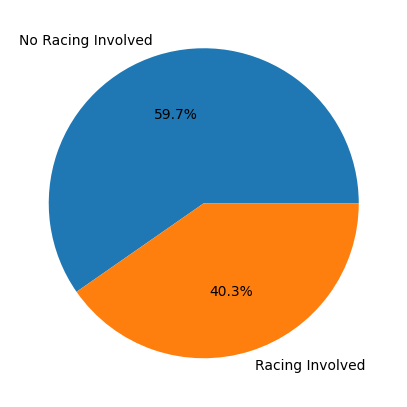

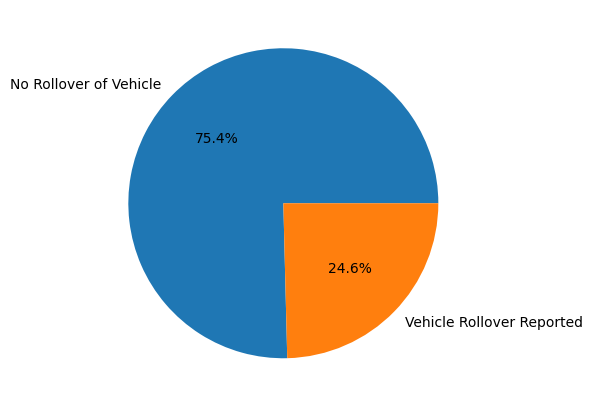

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Creating a DataFrame called 'dataset' and reading the data from 'FD_State_1,2014.csv' into it
dataset = pd.read_csv('FD_State_1,2014.csv',index_col=[0])
#dataset = inner_join
dataset.drop(['State Case','Case Year','Weather','Light_Type'], axis = 1, inplace = True)

#DRINKING_INVOLVEMENT PIE-CHART
#Defining the size of the figure
plt.figure(figsize=(5, 9))
#The frequency of each value present in the 'Drinking_Involvement' is calculated and stored as list
dataset_1 = dataset['Drinking_Involvement'].value_counts().values.tolist()
#Creating a pie chart with the mentioned labels, and percentages
plt.pie(dataset_1, labels = ['Not-Drunk','Not-Reported','Drunk'],autopct='%1.1f%%')

#DRUGS_INVOLVEMENT PIE-CHART
#Defining the size of the figure
plt.figure(figsize=(5, 9))
#The frequency of each value present in the 'Drugs_Involvement' column is calculated and stored as list
dataset_2 = dataset['Drugs_involvement'].value_counts().values.tolist()
#Creating a pie chart with the mentioned labels, and percentages
plt.pie(dataset_2, labels = ['No Drugs Involved','Not-Reported','Drugs Involvement Reported'], autopct='%1.1f%%')

#RACE_INVOLVEMENT PIE-CHART
#Defining the size of the figure
plt.figure(figsize=(5, 9))
#The frequency of each value present in the 'Race_Involvement' column is calculated and stored as list
dataset_3 = dataset['Race_Involvement'].value_counts().values.tolist()
#Creating a pie chart with the mentioned labels, and percentages
plt.pie(dataset_3, labels = ['No Racing Involved','Racing Involved'], autopct='%1.1f%%')

#ROLLOVER
#Defining the size of the figure
plt.figure(figsize=(5, 9))
#The frequency of each value present in the 'Rollover' column is calculated and stored as list
dataset_4 = dataset['Rollover'].value_counts().values.tolist()
#Creating a pie chart with the mentioned labels, and percentages
plt.pie(dataset_4, labels = ['No Rollover of Vehicle','Vehicle Rollover Reported'],autopct='%1.1f%%')


**Stacked Bar Plot for Descriptive Statistics for Individuals Involved in an Accident**

Text(0.5, 1.0, 'Individuals involved in an Accident by Age and Sex')

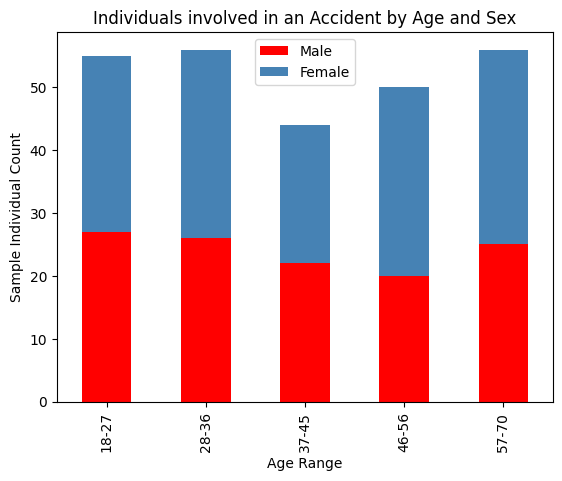

In [36]:
#Extracting the dataset for Female with Age category
#Female
dataset_age_female= dataset.loc[dataset['Sex']==2]
dataset_age_female= dataset_age_female['Age'].value_counts().rename_axis('Age').reset_index(name='Counts')
dataset_age_female= dataset_age_female.sort_values(by=['Age'])
dataset_age_female.reset_index(inplace = True)
dataset_age_female_final = pd.DataFrame({'18-27': dataset_age_female.loc[0:9,:]['Counts'],'28-36': dataset_age_female.loc[10:19,:]['Counts'],'37-45':dataset_age_female.loc[19:27,:]['Counts'],'46-56':dataset_age_female.loc[27:37,:]['Counts'],'57-70':dataset_age_female.loc[37:,:]['Counts']})
dataset_age_female_final1= dataset_age_female_final.sum().to_list()

#Extracting the dataset for Male with Age category
#Male
dataset_age_male= dataset.loc[dataset['Sex']==1]
dataset_age_male= dataset_age_male['Age'].value_counts().rename_axis('Age').reset_index(name='Counts')
dataset_age_male= dataset_age_male.sort_values(by=['Age'])
dataset_age_male.reset_index(inplace = True)
dataset_age_male_final = pd.DataFrame({'18-27': dataset_age_male.loc[0:9,:]['Counts'],'28-36': dataset_age_male.loc[10:19,:]['Counts'],'37-45':dataset_age_male.loc[19:28,:]['Counts'],'46-56':dataset_age_male.loc[28:39,:]['Counts'],'57-70':dataset_age_male.loc[39:,:]['Counts']})
dataset_age_male_final1= dataset_age_male_final.sum().to_list()

#Creating a dataframe for combining the values of Male and Female Age constrain
dataset_age_sex = pd.DataFrame({'Male': dataset_age_female_final1,
                                'Female': dataset_age_male_final1},
                               index = ['18-27','28-36','37-45','46-56','57-70'])

#Plotting a Seaborn Stacked Bar Graph
dataset_age_sex.plot(kind='bar',stacked = True, color =['red','steelblue'])
plt.xlabel('Age Range')
plt.ylabel('Sample Individual Count')
plt.title('Individuals involved in an Accident by Age and Sex')


**BOX PLOT FOR AGE VS INJURY SEVERITY LEVEL FOR ACCIDENTS**

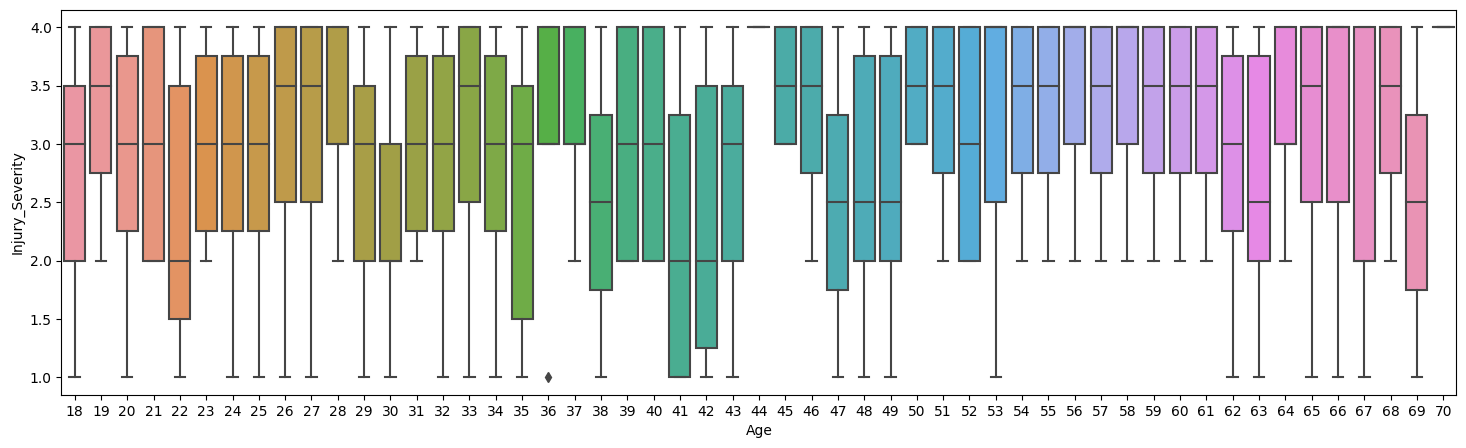

In [37]:
#CODE FOR BOX Plot - Age vs Severity Level

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))
sns.boxplot(x=dataset['Age'], y=dataset['Injury_Severity'])
plt.show()


**BOX PLOT FOR DRINKING INVOLVEMENT VS INJURY SEVERITY LEVEL**

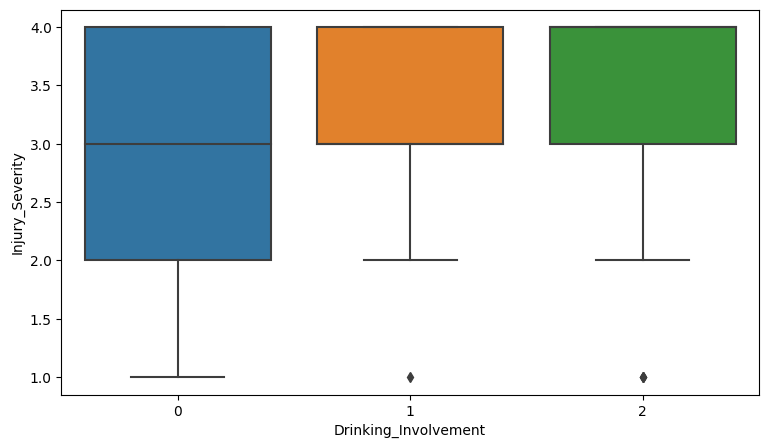

In [38]:
#CODE FOR Injurity Severity Level VS Drinking Involved

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
sns.boxplot(x="Drinking_Involvement", y="Injury_Severity", data=dataset)
plt.show()


**CALCULATING THE CORRELATION AMONG THE VARIABLES**

In [39]:
# Calculating the correlation among the variables
df_corr = dataset.corr()
df_corr

,Age,Sex,Drinking_Involvement,Drugs_involvement,Injury_Severity,Race_Involvement,Rollover,Clear,"Fog, Smog, Smoke",Weather Not Reported,Rain,Snow,Dark,Dawn/Dusk,Daylight
Age,1.000000,-0.038806,-0.065176,-0.103277,8.414677e-02,1.191409e-01,-0.158994,-0.054421,NaN,-0.102672,0.071429,0.110040,-0.045740,0.048710,2.550284e-02
Sex,-0.038806,1.000000,0.016266,-0.077732,3.120655e-02,2.369262e-02,-0.033734,0.003060,NaN,-0.027176,0.018133,-0.058214,-0.024189,-0.039801,4.048218e-02
Drinking_Involvement,-0.065176,0.016266,1.000000,0.827840,3.824450e-01,3.940232e-01,0.118605,0.019470,NaN,0.044047,-0.026250,-0.048569,-0.040152,0.040264,2.341490e-02
Drugs_involvement,-0.103277,-0.077732,0.827840,1.000000,3.034719e-01,2.794545e-01,0.193668,0.022946,NaN,0.071337,-0.039184,-0.050217,-0.034196,0.061658,8.672730e-03
Injury_Severity,0.084147,0.031207,0.382445,0.303472,1.000000e+00,8.324452e-01,0.113360,-0.005713,NaN,-0.060771,0.038548,-0.054820,0.046382,-0.112197,-7.551522e-18
Race_Involvement,0.119141,0.023693,0.394023,0.279454,8.324452e-01,1.000000e+00,0.103131,-0.012427,NaN,-0.015766,0.029370,-0.052302,0.040198,-0.097238,1.733936e-17
Rollover,-0.158994,-0.033734,0.118605,0.193668,1.133597e-01,1.031308e-01,1.000000,0.130938,NaN,0.022448,-0.139512,-0.036341,0.003866,-0.032091,9.362984e-03
Clear,-0.054421,0.003060,0.019470,0.022946,-5.712980e-03,-1.242740e-02,0.130938,1.000000,NaN,-0.292770,-0.924772,-0.168345,-0.094865,-0.155453,1.585012e-01
"Fog, Smog, Smoke",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weather Not Reported,-0.102672,-0.027176,0.044047,0.071337,-6.077074e-02,-1.576626e-02,0.022448,-0.292770,NaN,1.000000,-0.038678,-0.007041,0.120950,-0.023840,-1.106567e-01


**HEATMEAP FOR CORRELATION**

<Axes: >

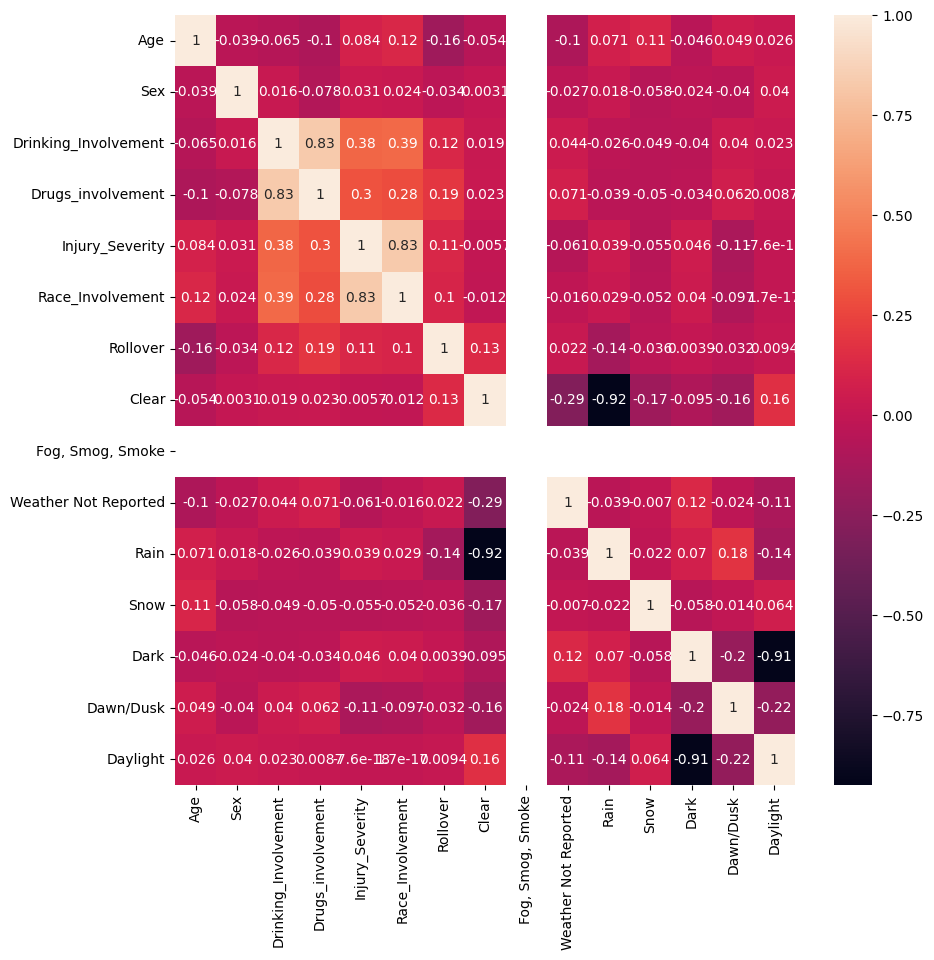

In [40]:
# Creating a Heatmap for Correlation
mask = np.array(df_corr)
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr,annot = True)

## **DATA ANALYSIS**




**Ordinal Regression - Logistic Regression**

In [79]:
y_data = dataset['Injury_Severity'] 
x_data = dataset.drop(['Injury_Severity'],axis = 1)

In [80]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# Splitting the dataset into Train and Test datasets
from sklearn.model_selection import train_test_split
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = 0.2)
len(x_training_data)

198

In [81]:
#Feeding the training data to the model
model.fit(x_training_data, y_training_data)
# Generating predictions for the test data
predictions = model.predict(x_test_data)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [82]:
from sklearn.metrics import classification_report
# Evaluating the performance of a classification model
print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.53      0.62      0.57        13
           3       0.44      0.47      0.45        15
           4       1.00      1.00      1.00        17

    accuracy                           0.64        50
   macro avg       0.49      0.52      0.51        50
weighted avg       0.61      0.64      0.62        50



In [70]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_data,predictions))

[[0 0 5 0]
 [0 3 4 4]
 [0 2 4 7]
 [1 9 6 5]]


**Naive Bayes**

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.20, random_state = 0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score
ac = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)
print(ac)
print(cm)

0.66
[[ 0  0  2  0]
 [ 1  0 14  0]
 [ 0  0  7  0]
 [ 0  0  0 26]]


**Random Forest Regression**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.20, random_state = 0)
X_train.shape, X_test.shape

from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)

classifier_rf.fit(X_train, y_train)
classifier_rf.oob_score_

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)
grid_search.best_score_
rf_best = grid_search.best_estimator_
rf_best

rf_best.feature_importances_
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})
imp_df.sort_values(by="Imp", ascending=False)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


,Varname,Imp
4,Race_Involvement,0.473470
2,Drinking_Involvement,0.198653
0,Age,0.111327
3,Drugs_involvement,0.080772
1,Sex,0.075639
11,Dark,0.034044
13,Daylight,0.022796
6,Clear,0.003298
5,Rollover,0.000000
7,"Fog, Smog, Smoke",0.000000


**Random Forest - Accuracy and Evaluation**

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.20, random_state = 0)
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

X_train shape: (198, 14)
X_test shape: (50, 14)
y_train shape: (198,)
y_test shape: (50,)


In [75]:


classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
classifier_rf.fit(X_train, y_train)


rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X_train, y_train)
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
ed = dtree.predict(X_test)

y_pred = dtree.predict(X_test)
print("Classification report - \n", classification_report(y_test,y_pred))

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Classification report - 
               precision    recall  f1-score   support

           1       0.22      1.00      0.36         2
           2       0.57      0.27      0.36        15
           3       0.38      0.43      0.40         7
           4       1.00      1.00      1.00        26

    accuracy                           0.70        50
   macro avg       0.54      0.67      0.53        50
weighted avg       0.75      0.70      0.70        50



In [77]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=10,
                       n_jobs=-1, random_state=42)

In [78]:
grid_search.best_score_

0.6314285714285715